# AIMET dependencies install & build
The following group of cells installs the AIMET library for you. For more details, please see [this link](https://github.com/quic/aimet/blob/develop/packaging/google_colab_install.md).

You can clone this notebook and use it in your own project. Make sure that before running these cells, you connect to a hosted environment with a GPU accelerator. (Runtime -> Change runtime -> Hardware Accelerator(GPU))

## Installing dependencies
May prompt you.
# Ignore first 4 code cells when running in docker!!!
## Start from "Train a model on MNIST data" :)

!pip3 uninstall --yes protobuf
!pip3 uninstall --yes tensorflow
!apt-get update
!apt-get install python3.6
!apt-get install python3-dev
!apt-get install python3-pip
!apt-get install liblapacke liblapacke-dev
!apt-get install wget
!pip3 install numpy==1.16.4
!apt-get install libgtest-dev build-essential cmake
!pip3 --no-cache-dir install opencv-python==4.1.0.25
!pip3 --no-cache-dir install pillow==6.2.1
!pip3 install pytorch-ignite==0.1.0
!wget -q https://github.com/Itseez/opencv/archive/3.1.0.tar.gz -O /tmp/3.1.0.tar.gz > /dev/null
!tar -C /tmp -xvf /tmp/3.1.0.tar.gz > /dev/null
%cd /tmp/opencv-3.1.0
%mkdir release
%cd release
!cmake -DCMAKE_POSITION_INDEPENDENT_CODE=ON -DBUILD_SHARED_LIBS=OFF -DCMAKE_BUILD_TYPE=release -DWITH_FFMPEG=OFF -DBUILD_TESTS=OFF -DWITH_CUDA=OFF -DBUILD_PERF_TESTS=OFF -DWITH_IPP=OFF -DENABLE_PRECOMPILED_HEADERS=OFF .. > /dev/null
!make -j16 > /dev/null
!make -j16 install > /dev/null
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!apt-get update
!apt install cuda-cublas-10-0 cuda-cufft-10-0 cuda-curand-10-0 cuda-cusolver-10-0
!apt-get update && apt install cuda-cusparse-10-0 libcudnn7=7.6.2.24-1+cuda10.0 libnccl2=2.4.8-1+cuda10.0  cuda-command-line-tools-10.0
!pip3 install scipy==1.1.0
!pip3 install protobuf==3.7.1
!pip3 install scikit-learn==0.19.1
!pip3 install tb-nightly==1.14.0a20190517
!pip3 install tensorboardX==1.7
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.4.0%2Bcu100-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.5.0%2Bcu100-cp36-cp36m-linux_x86_64.whl
!pip3 install --upgrade pip
!pip3 install tensorflow-gpu==1.15.0
!pip3 install future==0.17.1
!pip3 install tensorboard==1.14
!pip3 install bokeh==1.2.0
!pip3 install pandas==0.22.0
!pip3 install holoviews==1.12.7
!pip3 install --no-deps bokeh==1.2.0 hvplot==0.4.0
!pip3 install jsonschema==3.1.1
!pip3 install osqp onnx

!ln -s /usr/local/cuda-10.0 /usr/local/cuda
!apt-get update && apt-get install -y libjpeg8-dev
!ln -s /usr/lib/x86_64-linux-gnu/libjpeg.so /usr/lib

!apt install zlib1g-dev

!pip3 uninstall --yes Pillow && pip3 install Pillow-SIMD==6.0.0.post0
!pip3 uninstall --yes pytest
!pip3 install pytest
!pip3 install setuptools==41.0.1
!pip3 install keras==2.2.4

%rm -rf /usr/local/bin/python
!ln -s /usr/bin/python3 /usr/local/bin/python

After installing the dependencies, you must restart the environment before proceeding. (Runtime -> Restart Runtime)


## AIMET build and installation.

%cd /content/
!rm -rf aimet_code
!mkdir aimet_code
%cd aimet_code
!git clone https://github.com/quic/aimet.git
%cd aimet
%mkdir -p ./ThirdParty/googletest
%pushd ./ThirdParty/googletest
!git clone https://github.com/google/googletest.git -b release-1.8.0 googletest-release-1.8.0
%popd
%cd /content/aimet_code
%mkdir build
%cd build
!cmake -DCMAKE_EXPORT_COMPILE_COMMANDS=ON ../aimet
!make -j 8
!make install

## Setting up `PYTHONPATH` and `LD_LIBRARY_PATH`

import sys

sys.path.append(r'/content/aimet_code/build/staging/universal/lib/python')
sys.path.append(r'/content/aimet_code/build/staging/universal/lib/x86_64-linux-gnu')
sys.path.append(r'/usr/local/lib/python3.6/dist-packages')
sys.path.append(r'/content/aimet_code/build/artifacts')

import os

os.environ['LD_LIBRARY_PATH']+= ":/content/aimet_code/build/artifacts"

## Run unit tests
If the installation went smoothly, all tests should pass.

%cd /content/aimet_code/build/
!ctest

# Train a model on MNIST data

Set random seed for reprodubicility

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def display_grayscale(tensor):
    plt.imshow(tensor, cmap='gray')
    plt.show()

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Define a model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):          

    def __init__(self):     
        super(LeNet5, self).__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2),
                                    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2)
                                  )

        self.linears = nn.Sequential(nn.Linear(16*5*5, 120),
                                     nn.Linear(120, 84),
                                     nn.Linear(84, 10)
                                    )

    def forward(self, x):
        x = self.convs(x)
        x = x.flatten(start_dim=1)
        x = self.linears(x)

        return x

Define functions for creating imbalance

In [3]:
import math

def keep_selection(dataset, target, selection):
    ''' create imbalance in single class of a dataset '''
    
    # get indices of imgs of target number and remove selection of the indices
    target_mask = dataset.targets == target
    selection_idx = target_mask.nonzero()[round(len(target_mask.nonzero())*selection):]
    
    # make mask wich selects all data except for indices in selection
    selection_mask = np.ones(len(dataset.data), dtype=bool)
    selection_mask[selection_idx] = False
    
    # apply mask to remove the selected data
    dataset.data = dataset.data[selection_mask]
    dataset.targets = dataset.targets[selection_mask]


def keep_selections(dataset, selection_dict):
    ''' create imbalance in dataset according to selection dict '''
    
    # generate random ordered indeces for dataset
    datapoints = dataset.data.shape[0]
    rand_idx = torch.randperm(datapoints)
    
    # shuffle data and targets in the same way
    dataset.data = dataset.data[rand_idx]
    dataset.targets = dataset.targets[rand_idx]
    
    # throw away a part of the data for each class
    for class_number, selection in selection_dict.items():
        keep_selection(dataset, class_number, selection)
        
def linear_imbalance(dataset, ordered_classes, min_examples):
    ''' create selection dict with linear imbalance '''
    
    n_steps = len(ordered_classes) - 1
    linear_step = (1.0 - min_examples) / n_steps
    selection_dict = dict()
    
    # interpolate the classes between the minimum and maximum linearly
    for i, data_class in enumerate(ordered_classes):
        selection_dict[data_class] = min_examples + (i * linear_step)
    
    # make the selection from the dataset
    keep_selections(dataset, selection_dict)
    
    return selection_dict

def step_imbalance(dataset, ordered_classes, min_examples, step):
    ''' create selection dict with step imbalance '''
    
    n_classes = len(ordered_classes)
    selection_dict = dict()
    step_index = math.floor(step * n_classes)
    
    for i, data_class in enumerate(ordered_classes):
        if i < step_index:
            selection_dict[data_class] = min_examples
        else:
            selection_dict[data_class] = 1.0
    
    # make the selection from the dataset
    keep_selections(dataset, selection_dict)
    
    return selection_dict


def long_tailed_imbalance(dataset, ordered_classes, mu):
    ''' create selection dict with long-tailed imbalance'''
    selection_dict = dict()
    
    # set selection for each class according to long-tailed function, mu is in (0,1)
    for i, data_class in enumerate(ordered_classes):
        selection_dict[data_class] = mu**i
    
    # make the selection from the dataset
    keep_selections(dataset, selection_dict)
    
    return selection_dict


Define Dataloaders

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)


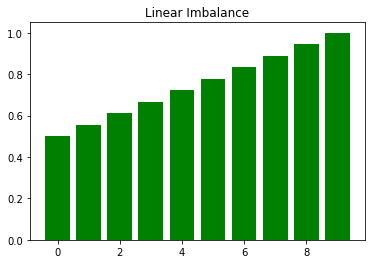

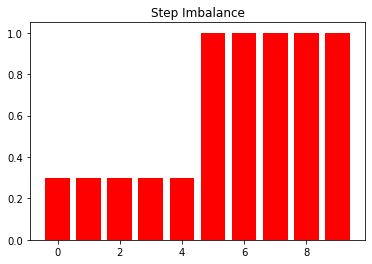

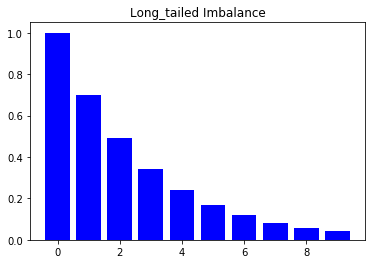

In [4]:
import torchvision.transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Convert imgs to tensor and normalize by mean and stddev of the training set
transformImg = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])
print(transformImg)

train = MNIST(root='./data', train=True, download=True, transform=transformImg)
test = MNIST(root='./data', train=False, download=True, transform=transformImg)

MNIST_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

linear_dict = linear_imbalance(train, MNIST_classes, 0.5)

plt.bar(linear_dict.keys(), linear_dict.values(), color='g')
plt.title('Linear Imbalance')
plt.show()

step_dict = step_imbalance(train, MNIST_classes, 0.3, 0.5)

plt.bar(step_dict.keys(), step_dict.values(), color='r')
plt.title('Step Imbalance')
plt.show()

long_tailed_dict = long_tailed_imbalance(train, MNIST_classes, 0.7)

plt.bar(long_tailed_dict.keys(), long_tailed_dict.values(), color='b')
plt.title('Long_tailed Imbalance')
plt.show()

MNIST_selection_dict = {0: .1, 1: .2, 2: .3, 3: .4, 4: .5, 5: .6, 6: .7, 7: .8, 8: .9, 9: 1.}

# applies unbalance to dataset
keep_selections(train, long_tailed_dict)

# Define train/test loaders
train_loader = DataLoader(train, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(train, batch_size=1024, num_workers=4, shuffle=False, pin_memory=True)

In [5]:
import torchvision.transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# Convert imgs to tensor and normalize by mean and stddev of the training set
transformImg = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])
print(transformImg)

train = MNIST(root='./data', train=True, download=True, transform=transformImg)
test = MNIST(root='./data', train=False, download=True, transform=transformImg)

def keep_selection(dataset, target, selection):
    ''' create imbalance in single class of a dataset '''
    
    # get indices of imgs of target number and remove selection of the indices
    target_mask = dataset.targets == target
    selection_idx = target_mask.nonzero()[round(len(target_mask.nonzero())*selection):]
    
    # make mask wich selects all data except for indices in selection
    selection_mask = np.ones(len(dataset.data), dtype=bool)
    selection_mask[selection_idx] = False
    
    # apply mask to remove the selected data
    dataset.data = dataset.data[selection_mask]
    dataset.targets = dataset.targets[selection_mask]


def keep_selections(dataset, selection_dict):
    ''' create imbalance in dataset according to selection dict '''
    
    # generate random ordered indeces for dataset
    datapoints = dataset.data.shape[0]
    rand_idx = torch.randperm(datapoints)
    
    # shuffle data and targets in the same way
    dataset.data = dataset.data[rand_idx]
    dataset.targets = dataset.targets[rand_idx]
    
    # throw away a part of the data for each class
    for class_number, selection in selection_dict.items():
        keep_selection(dataset, class_number, selection)
        
def linear_imbalance(dataset, ordered_classes, min_examples):
    ''' create selection dict with linear imbalance '''
    
    n_steps = len(ordered_classes) - 1
    linear_step = (1.0 - min_examples) / n_steps
    selection_dict = dict()
    
    # interpolate the classes between the minimum and maximum linearly
    for i, data_class in enumerate(ordered_classes):
        selection_dict[data_class] = min_examples + (i * linear_step)
    
    # make the selection from the dataset
    return keep_selections(dataset, selection_dict)

def step_imbalance(ordered_classes, min_examples, step):
    ''' create selection dict with step imbalance '''
    
    n_classes = len(ordered_classes)
    selection_dict = dict()
    step_index = floor(mean * n_classes)
    
    for i, data_class in enumerate(ordered_classes):
        if i <= step_index:
            selection_dict[data_class] = min_examples
        else:
            selection_dict[data_class] = 1.0
    
    # make the selection from the dataset
    return keep_selections(dataset, selection_dict)

def long_tailed_imbalance(ordered_classes, mu):
    ''' create selection dict with long-tailed imbalance'''
    selection_dict = dict()
    
    # set selection for each class according to long-tailed function, mu is in (0,1)
    for i, data_class in enumerate(ordered_classes):
        selection_dict[data_class] = mu**i
    
    return selection_dict


MNIST_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

linear_dict = linear_imbalance(MNIST_classes, 0.5)

plt.bar(linear_dict.keys(), linear_dict.values(), color='g')
plt.title('Linear Imbalance')
plt.show()

long_tailed_dict = long_tailed_imbalance(MNIST_classes, 0.7)

plt.bar(long_tailed_dict.keys(), long_tailed_dict.values(), color='b')
plt.title('Long_tailed Imbalance')
plt.show()


MNIST_selection_dict = {0: .1, 1: .2, 2: .3, 3: .4, 4: .5, 5: .6, 6: .7, 7: .8, 8: .9, 9: 1.}

# applies unbalance to dataset
keep_selections(train, long_tailed_dict)

# Define train/test loaders
train_loader = DataLoader(train, batch_size=128, num_workers=4, shuffle=True, pin_memory=True)
test_loader = DataLoader(train, batch_size=1024, num_workers=4, shuffle=False, pin_memory=True)

Compose(
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)


TypeError: linear_imbalance() missing 1 required positional argument: 'min_examples'

Define functions for conducting the training and testing epochs

In [8]:
def accuracy(out, y):
    preds = out.argmax(dim=1, keepdim=True).squeeze()
    correct = preds.eq(y).sum().item()
    return correct

def train_epoch(model, opt, train_loader, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    n_samples = 0
    for x,y in train_loader:
        opt.zero_grad()

        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss = criterion(out, y)

        epoch_acc += accuracy(out, y)
        epoch_loss += loss.item()
        n_samples += x.size(0)

        loss.backward()
        opt.step()

    epoch_acc = epoch_acc / n_samples
    epoch_loss = epoch_loss / n_samples

    return epoch_acc, epoch_loss



def test_epoch(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    n_samples = 0
    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model.forward(x)
            loss = criterion(out, y)

            epoch_acc += accuracy(out, y)
            epoch_loss += loss.item()
            n_samples += x.size(0)

    epoch_acc = epoch_acc / n_samples
    epoch_loss = epoch_loss / n_samples

    return epoch_acc, epoch_loss

Instantiate required objects and train

In [9]:
import torch.optim as optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter

# to use for weighted loss functions, values should be according to imbalance
weights = torch.FloatTensor([1,1,1,1,1,1,2,1,1,2])

criterion = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
writer = SummaryWriter()
model = LeNet5().to(device)
opt = optim.SGD(model.parameters(), lr=1e-2)

# Train+test, log to tensorboard
# It's recommended to also print all the scalar values
for i in range(n_epochs):
    train_acc, train_loss = train_epoch(model, opt, train_loader, criterion, device)
    test_acc, test_loss = test_epoch(model, test_loader, criterion, device)
    writer.add_scalar('train/acc', train_acc, i+1)
    writer.add_scalar('train/loss', train_loss, i+1)
    writer.add_scalar('test/acc', test_acc, i+1)
    writer.add_scalar('test/loss', test_loss, i+1)


Let's check out how the model did with tensorboard

In [10]:
%reload_ext tensorboard
!pip3 install tensorboard-plugin-wit
%tensorboard --logdir ./runs 

    100% |████████████████████████████████| 788kB 1.7MB/s eta 0:00:01
You are using pip version 9.0.1, however version 20.3.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Do channel pruning with AIMET

Import necessary stuff

In [11]:
from aimet_common.defs import CostMetric, CompressionScheme, GreedySelectionParameters
from aimet_torch.defs import ChannelPruningParameters
from aimet_torch.compress import ModelCompressor
from aimet_torch.onnx_utils import OnnxSaver
from decimal import Decimal

# Model compressor needs an evaluation function with this specific signature
def eval_callback(model, iterations, use_cuda=True):
    model.eval()
    epoch_acc = 0
    n_samples = 0
    with torch.no_grad():
        for idx,(x,y) in enumerate(test_loader):
            if use_cuda:
                x, y = x.to('cuda:0'), y.to('cuda:0')

            out = model.forward(x)
            epoch_acc += accuracy(out, y)
            n_samples += x.size(0)

            if iterations is not None:
                if idx == iterations:
                    break
        epoch_acc = epoch_acc / n_samples

    return epoch_acc


Do the actual pruning

In [12]:
greedy_params = GreedySelectionParameters(target_comp_ratio=Decimal(0.5))
# Exclude first layer from pruning
modules_to_ignore = [model.convs[0]]
auto_params = ChannelPruningParameters.AutoModeParams(greedy_params, modules_to_ignore)
input_shape = (1, 1, 28, 28)
channel_pruning_parameters = ChannelPruningParameters(mode=ChannelPruningParameters.Mode.auto,
                                                      params=auto_params,
                                                      data_loader=train_loader,
                                                      num_reconstruction_samples=1024,
                                                      allow_custom_downsample_ops=False,
                                                    #   multiplicity=8
                                                      )

# This takes a bit
comp_model_prun, stats_prun = ModelCompressor.compress_model(model,
                                                   input_shape=input_shape,
                                                   eval_callback=eval_callback,
                                                   eval_iterations=None,
                                                   compress_scheme=CompressionScheme.channel_pruning,
                                                   cost_metric=CostMetric.mac,
                                                   parameters=channel_pruning_parameters,
                                                   )


2021-01-13 10:15:47,995 - CompRatioSelect - INFO - Analyzing compression ratio: 0.1 =====================>
2021-01-13 10:15:48,027 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:48,225 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:48,453 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.100000 ==> eval_score=0.818600
2021-01-13 10:15:48,454 - CompRatioSelect - INFO - Analyzing compression ratio: 0.2 =====================>
2021-01-13 10:15:48,474 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:48,642 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:48,931 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.200000 ==> eval_score=0.819061
2021-01-13 10:15:48,932 - CompRatioSelect - INFO - Analyzing compression ratio: 0.3 =====================>
2021-01-13 10:15:48,959 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:49,144 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:49,392 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.300000 ==> eval_score=0.817680
2021-01-13 10:15:49,393 - CompRatioSelect - INFO - Analyzing compression ratio: 0.4 =====================>
2021-01-13 10:15:49,414 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:49,597 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:49,838 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.400000 ==> eval_score=0.846225
2021-01-13 10:15:49,839 - CompRatioSelect - INFO - Analyzing compression ratio: 0.5 =====================>
2021-01-13 10:15:49,859 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:50,037 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:50,303 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.500000 ==> eval_score=0.845764
2021-01-13 10:15:50,304 - CompRatioSelect - INFO - Analyzing compression ratio: 0.6 =====================>
2021-01-13 10:15:50,341 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:50,500 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:50,765 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.600000 ==> eval_score=0.847145
2021-01-13 10:15:50,766 - CompRatioSelect - INFO - Analyzing compression ratio: 0.7 =====================>
2021-01-13 10:15:50,786 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:50,983 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:51,233 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.700000 ==> eval_score=0.844843
2021-01-13 10:15:51,234 - CompRatioSelect - INFO - Analyzing compression ratio: 0.8 =====================>
2021-01-13 10:15:51,258 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:51,409 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:51,705 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.800000 ==> eval_score=0.844843
2021-01-13 10:15:51,706 - CompRatioSelect - INFO - Analyzing compression ratio: 0.9 =====================>
2021-01-13 10:15:51,736 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.


/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:51,928 - ChannelPruning - INFO - finished linear regression fit 
2021-01-13 10:15:52,202 - CompRatioSelect - INFO - Layer convs.3, comp_ratio 0.900000 ==> eval_score=0.844843
2021-01-13 10:15:52,204 - CompRatioSelect - INFO - Greedy selection: Saved eval dict to ./data/greedy_selection_eval_scores_dict.pkl
2021-01-13 10:15:52,207 - CompRatioSelect - INFO - Greedy selection: overall_min_score=0.817680, overall_max_score=0.847145
2021-01-13 10:15:52,209 - CompRatioSelect - INFO - Greedy selection: Original model cost=(Cost: memory=61470, mac=416520)
2021-01-13 10:15:52,242 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This 

/workspace/build/staging/universal/lib/python/aimet_torch/winnow/winnow_utils.py:186: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(tensor)  # pylint: disable=not-callable


2021-01-13 10:15:52,484 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward function, instead of as a class module. Redefine the op as a class module if possible. Else, check 3.
3. This op is one that cannot be defined as a class module, but has not been added to ConnectedGraph.functional_ops. Add to continue.
2021-01-13 10:15:52,509 - CompRatioSelect - INFO - Greedy selection: final choice - comp_ratio=0.427639, score=0.844843
2021-01-13 10:15:52,529 - ConnectedGraph - WARNING - Ops with missing modules: ['flatten_6']
This can be due to several reasons:
1. There is no mapping for the op in ConnectedGraph.op_type_map. Add a mapping for ConnectedGraph to recognize and be able to map the op.
2. The op is defined as a functional in the forward functi

Let's look at the two models. Can you see that `comp_model` has some missing channels in the convolutional layers?

In [14]:
print(stats_prun)
print('-'*10 + ' Original model ' + '-'*10)
print(model)
print('-'*10 + ' Compressed model ' + '-'*10)
print(comp_model_prun)

**********************************************************************************************
Compressed Model Statistics
Baseline model accuracy: 0.844383, Compressed model accuracy: 0.845304
Compression ratio for memory=0.972344, mac=0.427639

**********************************************************************************************

Per-layer Stats
    Name:convs.3, compression-ratio: 0.4

**********************************************************************************************

Greedy Eval Dict
    Layer: convs.3
        Ratio=0.1, Eval score=0.8186003683241252
        Ratio=0.2, Eval score=0.819060773480663
        Ratio=0.3, Eval score=0.8176795580110497
        Ratio=0.4, Eval score=0.8462246777163904
        Ratio=0.5, Eval score=0.8457642725598526
        Ratio=0.6, Eval score=0.8471454880294659
        Ratio=0.7, Eval score=0.8448434622467772
        Ratio=0.8, Eval score=0.8448434622467772
        Ratio=0.9, Eval score=0.8448434622467772

**************************

Now let's see how they compare in terms of speed.
Differences probably won't be huge here since the network is quite small to begin with, and only a single layer is pruned, but the point is to see that the compressed one is faster.

In [15]:
%timeit acc_full = eval_callback(model, None, use_cuda=True)
%timeit acc_comp = eval_callback(comp_model_prun, None, use_cuda=True)

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

# Noa's try at Spatial SVD with AIMET

In [ ]:
# Import the needed package
from aimet_torch.defs import SpatialSvdParameters
greedy_params = GreedySelectionParameters(target_comp_ratio=Decimal(0.5))
# Do not exclude anything in contrary to channel pruning
modules_to_ignore = []
auto_params = SpatialSvdParameters.AutoModeParams(greedy_params, modules_to_ignore)
input_shape = (1, 1, 28, 28)
# Delete all the parameters that don't give an error in channel pruning, but do here
spatial_svd_params = SpatialSvdParameters(mode=SpatialSvdParameters.Mode.auto,
                                                      params=auto_params)

# This takes a bit
comp_model_svd, stats_svd = ModelCompressor.compress_model(model,
                                                   input_shape=input_shape,
                                                   eval_callback=eval_callback,
                                                   eval_iterations=None,
                                                   compress_scheme=CompressionScheme.spatial_svd,
                                                   cost_metric=CostMetric.mac,
                                                   parameters=spatial_svd_params,
                                                   )

Look at the two models, but now compare it to the Spatial SVD one. You can see that the convolutional layers are split in two. What kind of effect this specificaly has, isn't clear yet.

In [ ]:
print(stats_svd)
print('-'*10 + ' Original model ' + '-'*10)
print(model)
print('-'*10 + ' Compressed model ' + '-'*10)
print(comp_model_svd)

Compare the speed difference between original model and this new compressed model.

In [ ]:
%timeit acc_full = eval_callback(model, None, use_cuda=True)
%timeit acc_comp = eval_callback(comp_model_svd, None, use_cuda=True)